## Test Notebook

In [1]:
import sys
from rdkit import Chem
from rdkit.Chem import AllChem
import rdkit.Chem.MolStandardize
import rdkit.Chem.MolStandardize.rdMolStandardize
import pandas as pd
import numpy as np
from pyteomics import mgf
import matplotlib.pyplot as plt
import spectrum_utils.plot as sup
import spectrum_utils.spectrum as sus
from data_utils import *
import operator
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import optimizers
import tensorflow as tf


print(sys.version)

RDKit WARNING: [15:38:56] Enabling RDKit 2019.09.1 jupyter extensions
Using TensorFlow backend.


3.7.5 (default, Oct 25 2019, 15:51:11) 
[GCC 7.3.0]


In [2]:
## Check GPU available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
unique_data = getData("MS_data_allGNPS_uniqueInchikey14_191101.mgf")
#large_data = getData("MS_data_allGNPS_smiles_191101.mgf")

# molecules:  8249


RDKit ERROR: [15:39:15] Can't kekulize mol.  Unkekulized atoms: 10 11 12 14 16
RDKit ERROR: 


unable to generate fp for entry 1257


RDKit ERROR: [15:39:15] SMILES Parse Error: unclosed ring for input: 'OC1=CC(C(OC)=O)=C(OC2=CC(C)=CC(O)=C2C(O)=O)C(OC)=C2'
RDKit ERROR: [15:39:15] SMILES Parse Error: unclosed ring for input: 'O=C1C2=C(C=C(C)C=C2O)OC3=CC(O)=CC(C(OC)=O)=C32'
RDKit ERROR: [15:39:15] SMILES Parse Error: unclosed ring for input: 'O=C([C@H](CC)C)O[C@H]1CCC=C2C1[C@@H](CC[C@@H](O)C[C@@H](O)CC(OC)=O)[C@@H](C)C=C3'
RDKit ERROR: [15:39:15] SMILES Parse Error: unclosed ring for input: 'O=C(N[C@@H](CCCCCC(CC)=O)C(N[C@@H](CC1=CN(OC)C2=C1C=CC=C2)C3=O)=O)[C@@H]4N(C([C@H]([C@H](CC)C)N3)=O)CCCC5'
RDKit ERROR: [15:39:15] SMILES Parse Error: unclosed ring for input: 'O=C(N(C(C=CC=C1)=C1C(N(C)[C@@]2([H])CC3=CC=CC=C3)=O)C2=N4)C5=C4C=CC=C6'
RDKit ERROR: [15:39:15] SMILES Parse Error: unclosed ring for input: 'OC1=CC=C(CC(C(NC(C(CC)C)C(OC(C(CCCCCCCCCC)C)CC(NC(C(NC(C(NC(C(NC2CCC(N)=O)=O)C)=O)C)=O)C(O)C)=O)=O)=O)NC2=O)C=C2'


unable to generate fp for entry 1318
unable to generate fp for entry 1320
unable to generate fp for entry 1340
unable to generate fp for entry 1346
unable to generate fp for entry 1351
unable to generate fp for entry 1356


RDKit ERROR: [15:39:17] non-ring atom 88 marked aromatic
RDKit ERROR: [15:39:17] non-ring atom 90 marked aromatic


unable to generate fp for entry 1855
unable to generate fp for entry 1856


RDKit WARNING: [15:39:36] WARNING: not removing hydrogen atom without neighbors
RDKit ERROR: [15:39:43] SMILES Parse Error: syntax error while parsing: N/A
RDKit ERROR: [15:39:43] SMILES Parse Error: Failed parsing SMILES 'N/A' for input: 'N/A'


unable to generate fp for entry 7214
# parsed molecules:  8239


In [4]:
## Test a random entry
mol = unique_data.iloc[7]
print(mol['m/z'])
print(mol['intensity'])
print(str(mol['fingerprint']))

[119.0494   150.014496 178.009506 234.994995 284.111511 312.106293
 355.112213]
[   5245.100098   59115.199219    6098.399902    3503.5
    4140.299805   58914.199219 1814529.375   ]
[0 0 0 ... 0 0 0]


In [5]:
def show_spectrum(spectrum_dict):
    spectrum = sus.MsmsSpectrum(spectrum_dict['title'], spectrum_dict['pepmass'][0], spectrum_dict['charge'][0], spectrum_dict['m/z'], spectrum_dict['intensity'])
    spectrum.filter_intensity(0)

    charge = spectrum_dict['charge'][0]
    tol_mass, tol_mode = 0.5, 'Da'
    annotate_fragment_mz = spectrum_dict['m/z']

    #for fragment_mz in annotate_fragment_mz:
    #spectrum.annotate_mz_fragment(fragment_mz, charge, tol_mass, tol_mode)

    fragment_smiles = spectrum_dict['SMILES']
    #fragment_mz = 295.170
    #spectrum.annotate_molecule_fragment(fragment_smiles, fragment_mz, charge, tol_mass, tol_mode)

    fig, ax = plt.subplots(figsize=(12, 6))
    sup.spectrum(spectrum, ax=ax)
    plt.show()
    plt.close()
    

In [22]:
data = unique_data.iloc[32]

num peaks: 
15


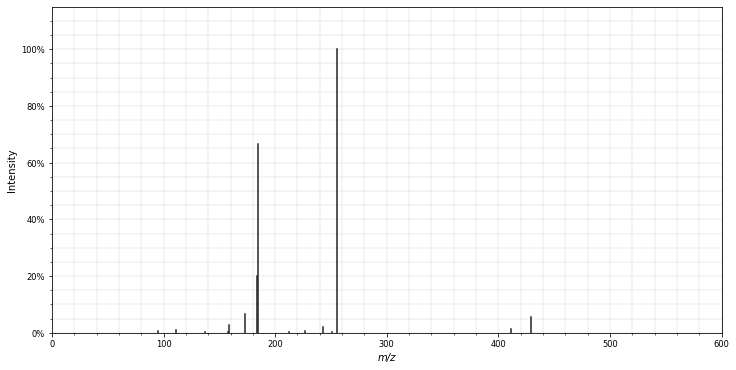

In [23]:
print("num peaks: ")
print(len(data['m/z']))
show_spectrum(data)

(0, 600.0)

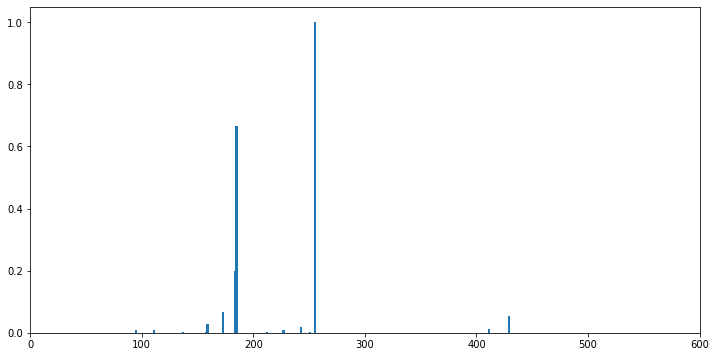

In [24]:
## verify binning results in a similar plot
bin_size = 1
binned = bin_spectra(data, bin_size)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()
ax.bar(range(len(binned)), binned, width=2)
ax.set_xlim(0, 600/bin_size)


In [25]:
def count_peaks(data, threshold):
    peak_counter = {i:0 for i in range(601)}
    for i, mol in data.iterrows():
        binned = bin_spectra(mol, 1)
        for bin_no, intensity in enumerate(binned):
            if intensity > threshold:
                peak_counter[bin_no] += 1
    
    return peak_counter

In [11]:
peaks = count_peaks(unique_data, 0.9)

/home/cameron/cs/project/src/data_utils.py:68: RuntimeWarning: invalid value encountered in true_divide
  return array / max(array)


In [13]:
## find most common large peak
max_peak = max(peaks.items(), key=operator.itemgetter(1))[0]

In [14]:
##### predict only bin 121
x_data = []
y_data = []

for i, mol in unique_data.iterrows():
    sys.stdout.write("Binning: %d   \r" % (i + 1) )
    sys.stdout.flush()
    binned = bin_spectra(mol, 1)
    x_data.append(mol['fingerprint'])
    y_data.append(binned[max_peak])
    
    
split = int(0.8 * len(x_data))
    
x_train = np.array(x_data[:split])
y_train = np.array(y_data[:split])

x_test = np.array(x_data[split:])
y_test = np.array(y_data[split:])

len(x_data)

8239

In [15]:
x2_data = []
y2_data = []

for i, val in enumerate(y_data):
    if val > 0.1:
        x2_data.append(x_data[i])
        y2_data.append(val)
        
split2 = int(0.8 * len(x2_data))
        
x2_train = np.array(x2_data[:split2])
y2_train = np.array(y2_data[:split2])

x2_test = np.array(x2_data[split2:])
y2_test = np.array(y2_data[split2:])

len(x2_data)

844

In [16]:
### First working MLP
# model = Sequential()
# model.add(Dense(units=1024, activation='sigmoid', input_shape=(2048,)))
# model.add(Dense(units=64, activation='relu'))
# model.add(Dense(1, activation='linear'))
# sgd = optimizers.SGD(lr=0.01, nesterov=True);
# model.compile(loss='mean_absolute_error', optimizer=sgd)

In [17]:
model = Sequential()
model.add(Dense(units=512, activation='sigmoid', input_shape=(2048,)))

#model.add(Dense(units=256, activation='relu'))
#model.add(Dropout(0.25))
#model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=32, activation='relu'))
#model.add(Dropout(0.25))
model.add(Dense(1))

#model.compile(optimizer='adam', loss='mse', metrics=['mean_absolute_error'])
#model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_squared_error'])
#model.fit(np.array(x_data), np.array(y_data), epochs=10, batch_size=10, verbose=1, validation_split=0.2)


sgd = optimizers.SGD(lr=0.01, nesterov=True);
rmsprop = optimizers.RMSprop(learning_rate=0.001, rho=0.9)
model.compile(loss='mean_absolute_error', optimizer="rmsprop", metrics=['mse', 'mae', 'mape', 'cosine'])

In [21]:
model.fit(x2_train, y2_train, epochs=20, batch_size=128, validation_split=0.2, verbose=1)

Train on 540 samples, validate on 135 samples
Epoch 1/20
540/540 [==============================] - 0s 187us/step - loss: 0.1941 - mse: 0.0772 - mae: 0.1941 - mape: 57.2520 - cosine: 1.0000 - val_loss: 0.2203 - val_mse: 0.0999 - val_mae: 0.2203 - val_mape: 70.3317 - val_cosine: 1.0000
Epoch 2/20
540/540 [==============================] - 0s 175us/step - loss: 0.1585 - mse: 0.0585 - mae: 0.1585 - mape: 50.8572 - cosine: 0.9741 - val_loss: 0.2275 - val_mse: 0.1055 - val_mae: 0.2275 - val_mape: 70.7247 - val_cosine: 1.0000
Epoch 3/20
540/540 [==============================] - 0s 155us/step - loss: 0.1588 - mse: 0.0596 - mae: 0.1588 - mape: 47.8608 - cosine: 1.0000 - val_loss: 0.2461 - val_mse: 0.1157 - val_mae: 0.2461 - val_mape: 78.1072 - val_cosine: 1.0000
Epoch 4/20
540/540 [==============================] - 0s 175us/step - loss: 0.1414 - mse: 0.0532 - mae: 0.1414 - mape: 43.0748 - cosine: 1.0000 - val_loss: 0.1940 - val_mse: 0.0879 - val_mae: 0.1940 - val_mape: 58.3544 - val_cosine: 1

In [19]:
results = model.evaluate(x2_test, y2_test, batch_size=128, verbose=1)
labels = model.metrics_names

for i in range(len(results)):
    print(labels[i], results[i])

169/169 [==============================] - 0s 74us/step
loss 0.2579442962739595
mse 0.09799472242593765
mae 0.2579442858695984
mape 132.38230895996094
cosine 1.0
